In [1]:
#Run libraries
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#Read csv file
original_data = pd.read_csv('CAHPS_data_20180101-20240401.csv', low_memory =False)

In [5]:
#Display first rows
original_data.head()

,SURVEY_ID,CLIENT_ID,SERVICE,DISDATE,CLIENT_DESC,GROUPER_1,SEX,AGE_AT_DISCH,RACE,INSURANC,...,I3,I4,I5,I6,N114,SS5,SS131,O2,O3,O4
0,1793037887,1712,PY,NaN,Abington Memorial,Abington,Female,29.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5343067819,1712,OY,NaN,Abington Memorial,Abington,NaN,NaN,White or Caucasian,NaN,...,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5291417966,1712,OY,NaN,Abington Memorial,Abington,NaN,NaN,Black or African American,NaN,...,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5291407751,1712,OY,NaN,Abington Memorial,Abington,NaN,NaN,White or Caucasian,NaN,...,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1493151011,1712,PY,NaN,Abington Memorial,Abington,Male,26.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Filter data so only data starting from 2017 is used

#Convert DISDATE column to datetime format
original_data['DISDATE'] = pd.to_datetime(original_data['DISDATE'], errors='coerce')


#Filter rows where DISDATE is on or after January 1, 2017
hosp_data = original_data[original_data['DISDATE'].dt.year >= 2017]

In [7]:
#Show first rows of columns
hosp_data.head()

,SURVEY_ID,CLIENT_ID,SERVICE,DISDATE,CLIENT_DESC,GROUPER_1,SEX,AGE_AT_DISCH,RACE,INSURANC,...,I3,I4,I5,I6,N114,SS5,SS131,O2,O3,O4
364,1493151269,1712,PY,2017-01-17,Abington Memorial,Abington,Male,74.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365,1332145446,1712,ON,2017-04-30,Abington Memorial,Abington,Female,68.0,W,MEDICARE,...,5.0,5.0,5.0,5.0,NaN,NaN,NaN,5.0,5.0,NaN
366,1332896171,1712,ER,2017-05-27,Abington Memorial,Abington,Female,42.0,B,KEYSTONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367,1331661364,1712,MD,2017-06-02,Abington Memorial,Abington,Male,64.0,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0
368,1337724285,1712,IN,2017-06-08,Abington Memorial,Abington,Female,56.0,W,MEDICARE,...,3.0,3.0,2.0,3.0,NaN,NaN,NaN,4.0,5.0,4.0


In [8]:
#Set display options to show all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Check for missing values
missing_values = hosp_data.isnull().sum()
print(missing_values)

#I am not deleting all of these NA columns as these could delete a lot of data since many survey respondents may have chosen to skip some questions.
#Even if they skipped some questions, the questions they did answer are still valuable.

SURVEY_ID             0
CLIENT_ID             0
SERVICE               0
DISDATE               0
CLIENT_DESC           0
GROUPER_1             0
SEX               35714
AGE_AT_DISCH      36529
RACE              41332
INSURANC         688940
ZIP_CODE         587723
CMS_1           1286117
CMS_2           1286171
CMS_3           1286209
CMS_37          1296885
CMS_37CL        1297207
CMS_6           1286340
CMS_7           1286523
CMS_8           1286850
CMS_10          1287094
CMS_11          1287422
CMS_12          1288679
CMS_13          1325853
CMS_13CL        1328877
CMS_18          1289010
CMS_33          1313555
CMS_19          1314598
CMS_19CL        1318712
CMS_20          1286428
CMS_21          1294538
CMS_21CL        1296361
CMS_22          1294967
CMS_22CL        1296536
CMS_23          1286610
CMS_24          1286878
CMS_38          1288780
CMS_39          1287404
CMS_40          1287612
CMS_41          1286724
CMS_25          1288089
CMS_26          1288049
CMS_27          

In [9]:
#Reviewing the data types for the columns with patient information

#List of the first 11 columns
first_11_columns = ['SURVEY_ID', 'CLIENT_ID', 'SERVICE', 'DISDATE', 'CLIENT_DESC', 'GROUPER_1', 'SEX', 'AGE_AT_DISCH', 'RACE', 'INSURANC', 'ZIP_CODE']

#Check the data types for these columns
first_11_data_types = hosp_data[first_11_columns].dtypes
print(first_11_data_types)

SURVEY_ID                int64
CLIENT_ID                int64
SERVICE                 object
DISDATE         datetime64[ns]
CLIENT_DESC             object
GROUPER_1               object
SEX                     object
AGE_AT_DISCH           float64
RACE                    object
INSURANC                object
ZIP_CODE                object
dtype: object


In [11]:
#Reviewing the data types for the CMS columns. These columns have the survey questions.

#Get all column names
all_columns = hosp_data.columns

#Filter columns that start with 'CMS'
cms_columns = [col for col in all_columns if col.startswith('CMS')]

#Check data types for these columns
cms_dtypes = hosp_data[cms_columns].dtypes

#Print data types
print(cms_dtypes)


CMS_1       object
CMS_2       object
CMS_3       object
CMS_37      object
CMS_37CL    object
CMS_6       object
CMS_7       object
CMS_8       object
CMS_10      object
CMS_11      object
CMS_12      object
CMS_13      object
CMS_13CL    object
CMS_18      object
CMS_33      object
CMS_19      object
CMS_19CL    object
CMS_20      object
CMS_21      object
CMS_21CL    object
CMS_22      object
CMS_22CL    object
CMS_23      object
CMS_24      object
CMS_38      object
CMS_39      object
CMS_40      object
CMS_41      object
CMS_25      object
CMS_26      object
CMS_27      object
CMS_28      object
CMS_29A     object
CMS_29B     object
CMS_29C     object
CMS_29D     object
CMS_29E     object
CMS_30      object
dtype: object


In [4]:
#Convert column CMS_23 to numerical type since the values are numbers
hosp_data['CMS_23'] = pd.to_numeric(hosp_data['CMS_23'], errors='coerce')

C:\Users\ariia\AppData\Local\Temp\ipykernel_20324\2314091678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp_data['CMS_23'] = pd.to_numeric(hosp_data['CMS_23'], errors='coerce')


In [5]:
#Create new columns DIS_YEAR and DIS_MONTH from DISDATE column
hosp_data['DIS_YEAR'] = hosp_data['DISDATE'].dt.year
hosp_data['DIS_MONTH'] = hosp_data['DISDATE'].dt.month

#View the new columns
print(hosp_data[['DISDATE', 'DIS_YEAR', 'DIS_MONTH']].head())

       DISDATE  DIS_YEAR  DIS_MONTH
364 2017-01-17      2017          1
365 2017-04-30      2017          4
366 2017-05-27      2017          5
367 2017-06-02      2017          6
368 2017-06-08      2017          6


C:\Users\ariia\AppData\Local\Temp\ipykernel_20324\1008122538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp_data['DIS_YEAR'] = hosp_data['DISDATE'].dt.year
C:\Users\ariia\AppData\Local\Temp\ipykernel_20324\1008122538.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp_data['DIS_MONTH'] = hosp_data['DISDATE'].dt.month


In [14]:
#See the value count for a column
value_counts = hosp_data['CMS_1'].value_counts(dropna=False)

#Print value count
print(value_counts)

CMS_1
NaN          1286117
Always         79571
Usually         9813
Sometimes       2899
Never            345
Name: count, dtype: int64


In [15]:
#Run statistics
print(hosp_data.describe())

          SURVEY_ID     CLIENT_ID                        DISDATE  \
count  1.378745e+06  1.378745e+06                        1378745   
mean   3.614771e+09  9.620219e+03  2021-09-26 19:37:44.270477568   
min    9.129618e+08  1.730000e+02            2017-01-17 00:00:00   
25%    2.228153e+09  1.712000e+03            2020-02-11 00:00:00   
50%    3.135525e+09  6.319000e+03            2022-03-01 00:00:00   
75%    5.110810e+09  6.986000e+03            2023-06-01 00:00:00   
max    6.608785e+09  4.058400e+04            2024-10-23 00:00:00   
std    1.614131e+09  1.156765e+04                            NaN   

       AGE_AT_DISCH        CMS_23             A1            A3            R1  \
count  1.342216e+06  49531.000000  911798.000000  57827.000000  47149.000000   
mean   6.181851e+01      7.627203       4.609658      4.507998      4.148996   
min    0.000000e+00      1.000000       1.000000      1.000000      1.000000   
25%    5.400000e+01      7.000000       4.000000      4.000000     

C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\1305735882.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DIS_YEAR', data=hosp_data, palette='viridis')


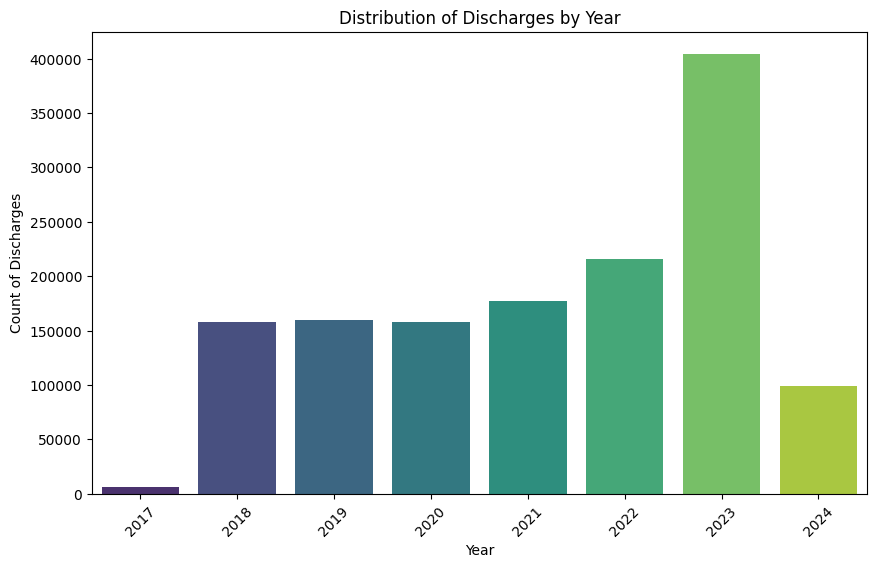

In [16]:
#Create graph for the distribution of discharges by year
plt.figure(figsize=(10, 6))
sns.countplot(x='DIS_YEAR', data=hosp_data, palette='viridis')
plt.title('Distribution of Discharges by Year')
plt.xlabel('Year')
plt.ylabel('Count of Discharges')
plt.xticks(rotation=45)
plt.show()

C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\2105862920.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DIS_MONTH', data=hosp_data, palette='viridis')


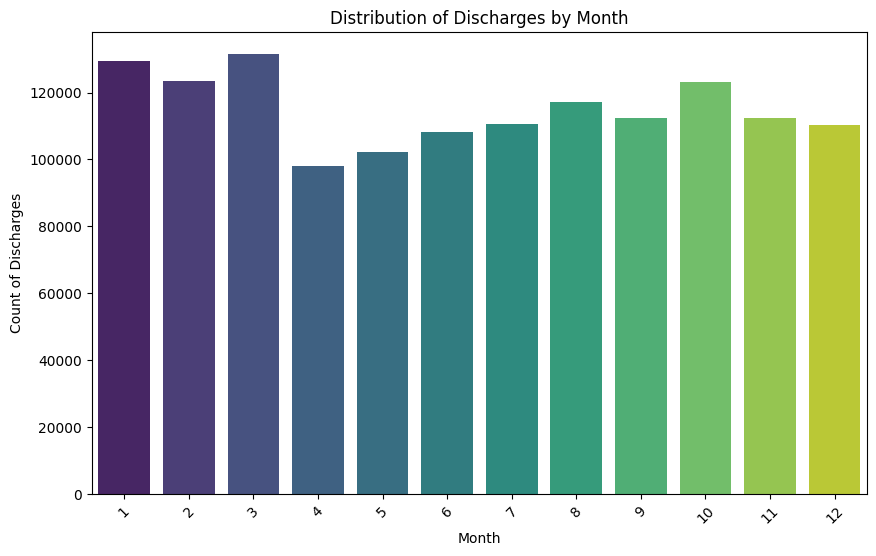

In [17]:
#Create graph for discharges by month
plt.figure(figsize=(10, 6))
sns.countplot(x='DIS_MONTH', data=hosp_data, palette='viridis')
plt.title('Distribution of Discharges by Month')
plt.xlabel('Month')
plt.ylabel('Count of Discharges')
plt.xticks(rotation=45)
plt.show()

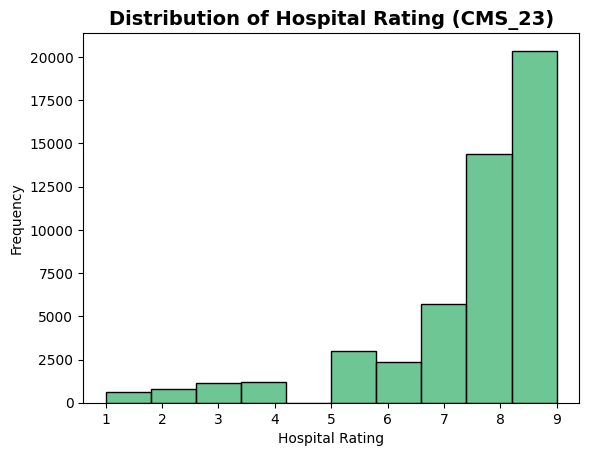

In [18]:
#Create Histogram of hospital ratings from CMS_23
sns.histplot(hosp_data['CMS_23'], bins=10, color='mediumseagreen', kde=False, edgecolor='black')

#Add title and labels
plt.title('Distribution of Hospital Rating (CMS_23)', fontsize=14, fontweight='bold')
plt.xlabel('Hospital Rating')
plt.ylabel('Frequency')

#Show the plot
plt.show()

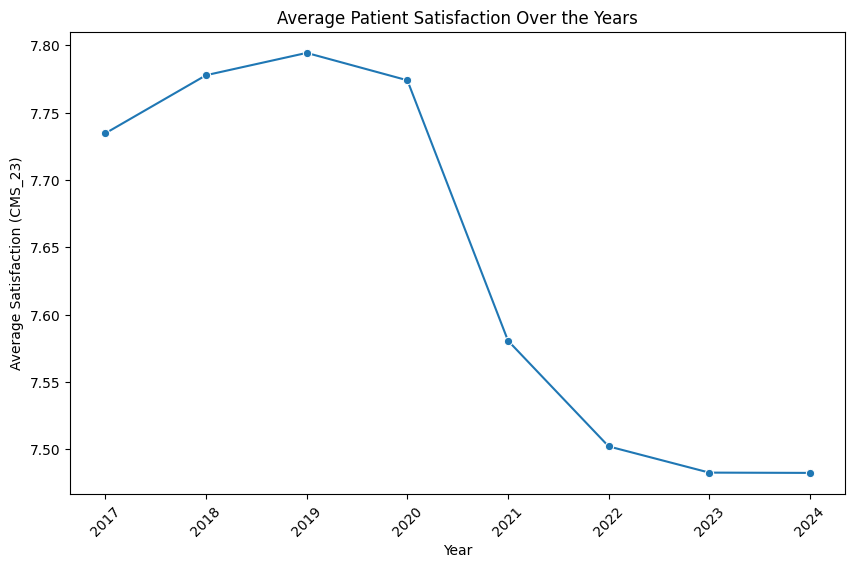

In [19]:
#Create graph for average patient satisfaction over the years
plt.figure(figsize=(10, 6))
avg_satisfaction_by_year = hosp_data.groupby('DIS_YEAR')['CMS_23'].mean().reset_index()
sns.lineplot(x='DIS_YEAR', y='CMS_23', data=avg_satisfaction_by_year, marker='o')
plt.title('Average Patient Satisfaction Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Satisfaction (CMS_23)')
plt.xticks(rotation=45)
plt.show()

C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\1996005538.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp_data[col] = hosp_data[col].map(ordinal_mapping)
C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\1996005538.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp_data[col] = hosp_data[col].map(ordinal_mapping)
C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\1996005538.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

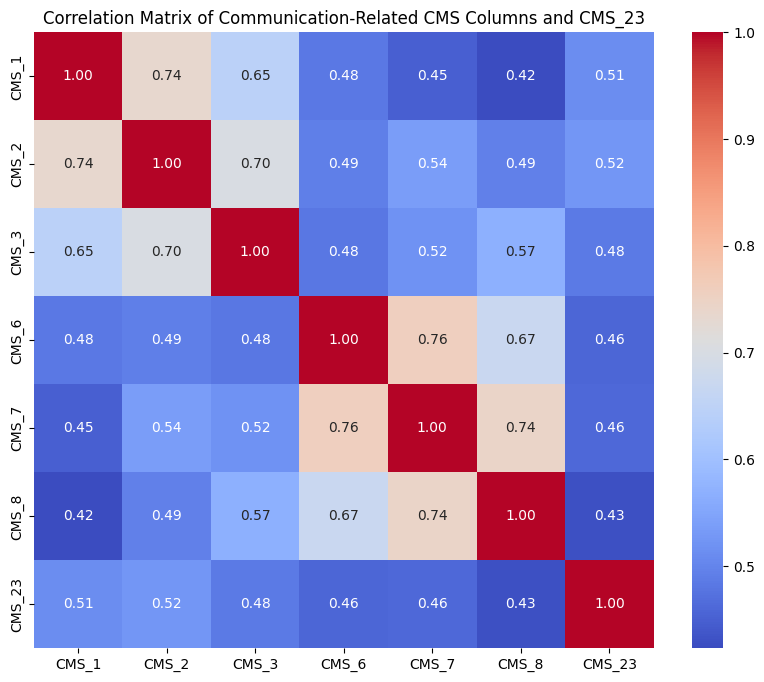

In [20]:
#Create Correlation Graph
#Set variable for CMS columns that are related to communication by hospital staff
communication_columns = ['CMS_1', 'CMS_2', 'CMS_3', 'CMS_6', 'CMS_7', 'CMS_8']

#Define a mapping for the ordinal categories to numeric values
ordinal_mapping = {
    'NULL': 0,  
    'Never': 1,
    'Sometimes': 2,
    'Usually': 3,
    'Always': 4
}

#Apply the mapping to the communication columns
for col in communication_columns:
    hosp_data[col] = hosp_data[col].map(ordinal_mapping)

#Make sure CMS_23 is numeric
hosp_data['CMS_23'] = pd.to_numeric(hosp_data['CMS_23'], errors='coerce')

#Calculate the correlation matrix
correlation_matrix = hosp_data[communication_columns + ['CMS_23']].corr()

#Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Communication-Related CMS Columns and CMS_23')
plt.show()

C:\Users\ariia\AppData\Local\Temp\ipykernel_20324\2902138432.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp_data['CMS_23'] = pd.to_numeric(hosp_data['CMS_23'], errors='coerce')


       CMS_1    CMS_2    CMS_3  CMS_23
368  Usually  Usually  Usually     8.0
400   Always   Always  Usually     9.0
401   Always   Always   Always     9.0
406  Usually  Usually   Always     9.0
409   Always   Always   Always     9.0
CMS_1      object
CMS_2      object
CMS_3      object
CMS_23    float64
dtype: object


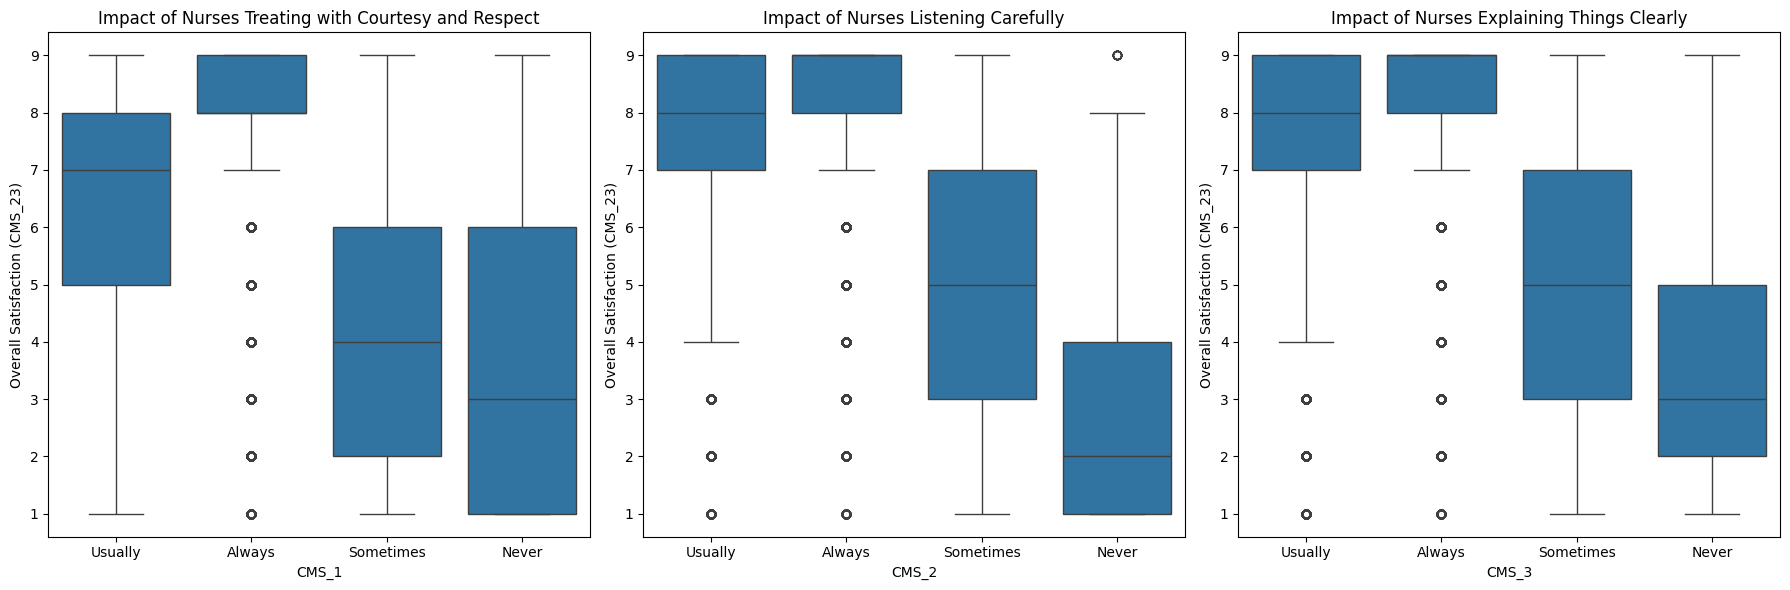

In [7]:
#Nurse box plots

#Set variable for CMS columns related to nurse communication
nurse_communication_columns = ['CMS_1', 'CMS_2', 'CMS_3']

#Make sure CMS_23 is numeric
hosp_data['CMS_23'] = pd.to_numeric(hosp_data['CMS_23'], errors='coerce')

#Drop rows with missing values in the relevant columns
hosp_data_clean = hosp_data.dropna(subset=nurse_communication_columns + ['CMS_23'])

#Check if data is still present
print(hosp_data_clean[nurse_communication_columns + ['CMS_23']].head())
print(hosp_data_clean[nurse_communication_columns + ['CMS_23']].dtypes)

#Plot
plt.figure(figsize=(18, 6))

#Create Boxplot for CMS_1
plt.subplot(1, 3, 1)
sns.boxplot(x='CMS_1', y='CMS_23', data=hosp_data_clean)
plt.title('Impact of Nurses Treating with Courtesy and Respect')
plt.xlabel('CMS_1')
plt.ylabel('Overall Satisfaction (CMS_23)')

#Create Boxplot for CMS_2
plt.subplot(1, 3, 2)
sns.boxplot(x='CMS_2', y='CMS_23', data=hosp_data_clean)
plt.title('Impact of Nurses Listening Carefully')
plt.xlabel('CMS_2')
plt.ylabel('Overall Satisfaction (CMS_23)')

#Create Boxplot for CMS_3
plt.subplot(1, 3, 3)
sns.boxplot(x='CMS_3', y='CMS_23', data=hosp_data_clean)
plt.title('Impact of Nurses Explaining Things Clearly')
plt.xlabel('CMS_3')
plt.ylabel('Overall Satisfaction (CMS_23)')

plt.tight_layout()
plt.show()

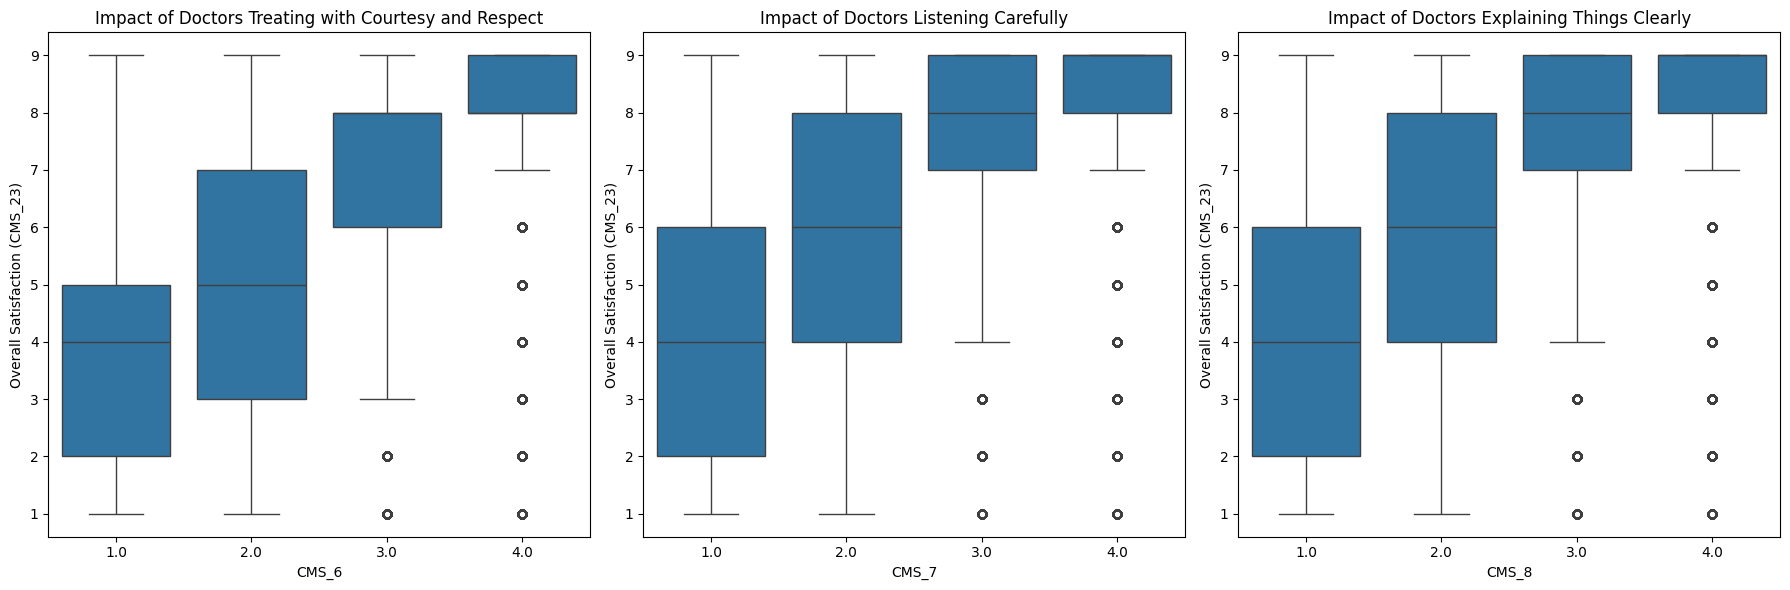

In [22]:
#Doctor box plots

#Set variable for doctor CMS columns
doctor_communication_columns = ['CMS_6', 'CMS_7', 'CMS_8']  

#Plotting
plt.figure(figsize=(18, 6))

#Create Boxplot for CMS_6
plt.subplot(1, 3, 1)
sns.boxplot(x='CMS_6', y='CMS_23', data=hosp_data_clean)
plt.title('Impact of Doctors Treating with Courtesy and Respect')
plt.xlabel('CMS_6')
plt.ylabel('Overall Satisfaction (CMS_23)')

#Create Boxplot for CMS_7
plt.subplot(1, 3, 2)
sns.boxplot(x='CMS_7', y='CMS_23', data=hosp_data_clean)
plt.title('Impact of Doctors Listening Carefully')
plt.xlabel('CMS_7')
plt.ylabel('Overall Satisfaction (CMS_23)')

#Create Boxplot for CMS_8
plt.subplot(1, 3, 3)
sns.boxplot(x='CMS_8', y='CMS_23', data=hosp_data_clean)
plt.title('Impact of Doctors Explaining Things Clearly')
plt.xlabel('CMS_8')
plt.ylabel('Overall Satisfaction (CMS_23)')

plt.tight_layout()
plt.show()

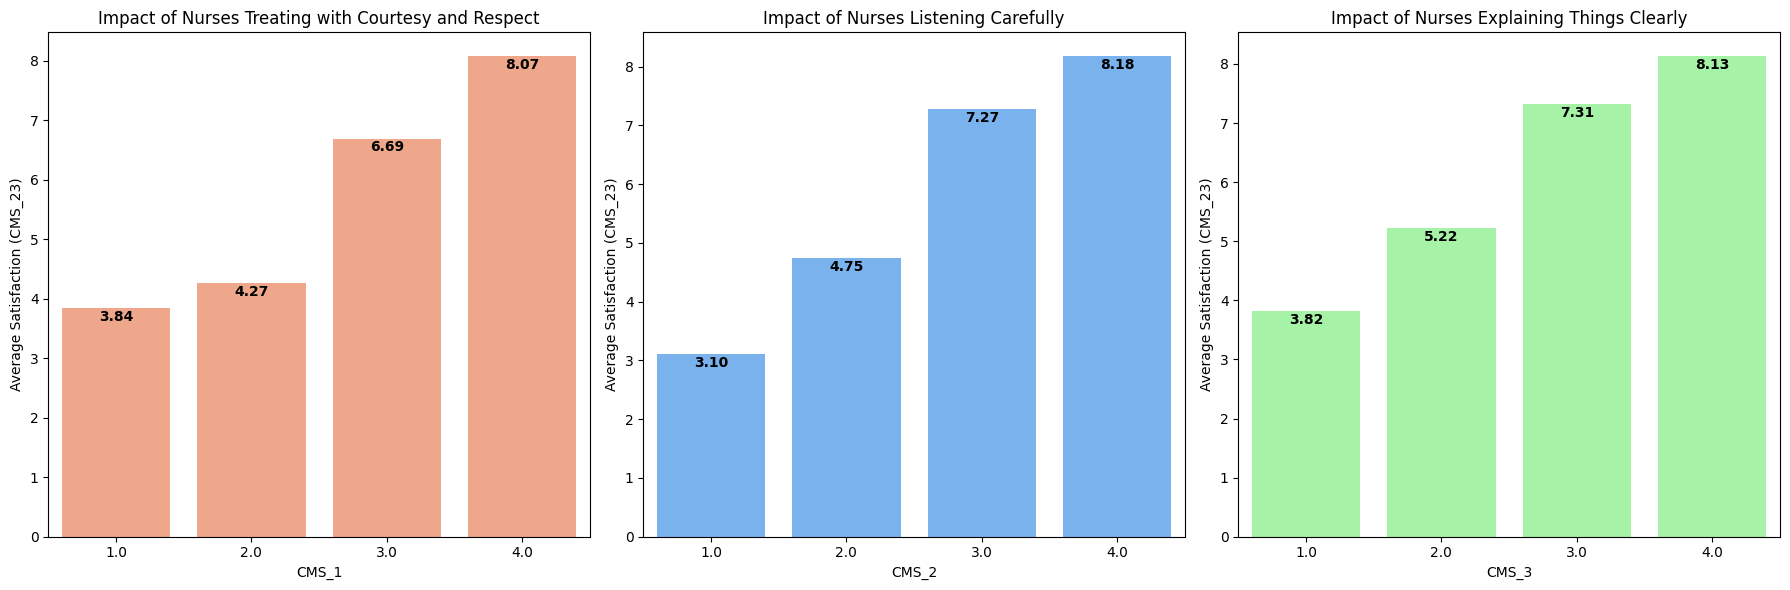

In [23]:
#Nurse Bar Graphs

#Set a palette for nurse graphs
color_palette = sns.color_palette("husl", 5)  

#Set palette for bar plots
colors = ["#FFA07A", "#66B2FF", "#99FF99"]  #LightSalmon, LightSeaGreen, Gold

#Plotting
plt.figure(figsize=(18, 6))

#Bar plot for CMS_1
plt.subplot(1, 3, 1)
ax1 = sns.barplot(x='CMS_1', y='CMS_23', data=hosp_data_clean, errorbar=None, color=colors[0])
plt.title('Impact of Nurses Treating with Courtesy and Respect')
plt.xlabel('CMS_1')
plt.ylabel('Average Satisfaction (CMS_23)')

#Annotate bars for CMS_1
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(format(height, '.2f'), 
                 (p.get_x() + p.get_width() / 2., height - 0.15), 
                 ha='center', va='center', 
                 xytext=(0, 0), 
                 textcoords='offset points',
                 color='black', weight='bold')

#Bar plot for CMS_2
plt.subplot(1, 3, 2)
ax2 = sns.barplot(x='CMS_2', y='CMS_23', data=hosp_data_clean, errorbar=None, color=colors[1])
plt.title('Impact of Nurses Listening Carefully')
plt.xlabel('CMS_2')
plt.ylabel('Average Satisfaction (CMS_23)')

#Annotate bars for CMS_2
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(format(height, '.2f'), 
                 (p.get_x() + p.get_width() / 2., height - 0.15), 
                 ha='center', va='center', 
                 xytext=(0, 0), 
                 textcoords='offset points',
                 color='black', weight='bold')

#Bar plot for CMS_3
plt.subplot(1, 3, 3)
ax3 = sns.barplot(x='CMS_3', y='CMS_23', data=hosp_data_clean, errorbar=None, color=colors[2])
plt.title('Impact of Nurses Explaining Things Clearly')
plt.xlabel('CMS_3')
plt.ylabel('Average Satisfaction (CMS_23)')

#Annotate bars for CMS_3
for p in ax3.patches:
    height = p.get_height()
    ax3.annotate(format(height, '.2f'), 
                 (p.get_x() + p.get_width() / 2., height - 0.15), 
                 ha='center', va='center', 
                 xytext=(0, 0), 
                 textcoords='offset points',
                 color='black', weight='bold')

plt.tight_layout()
plt.show()

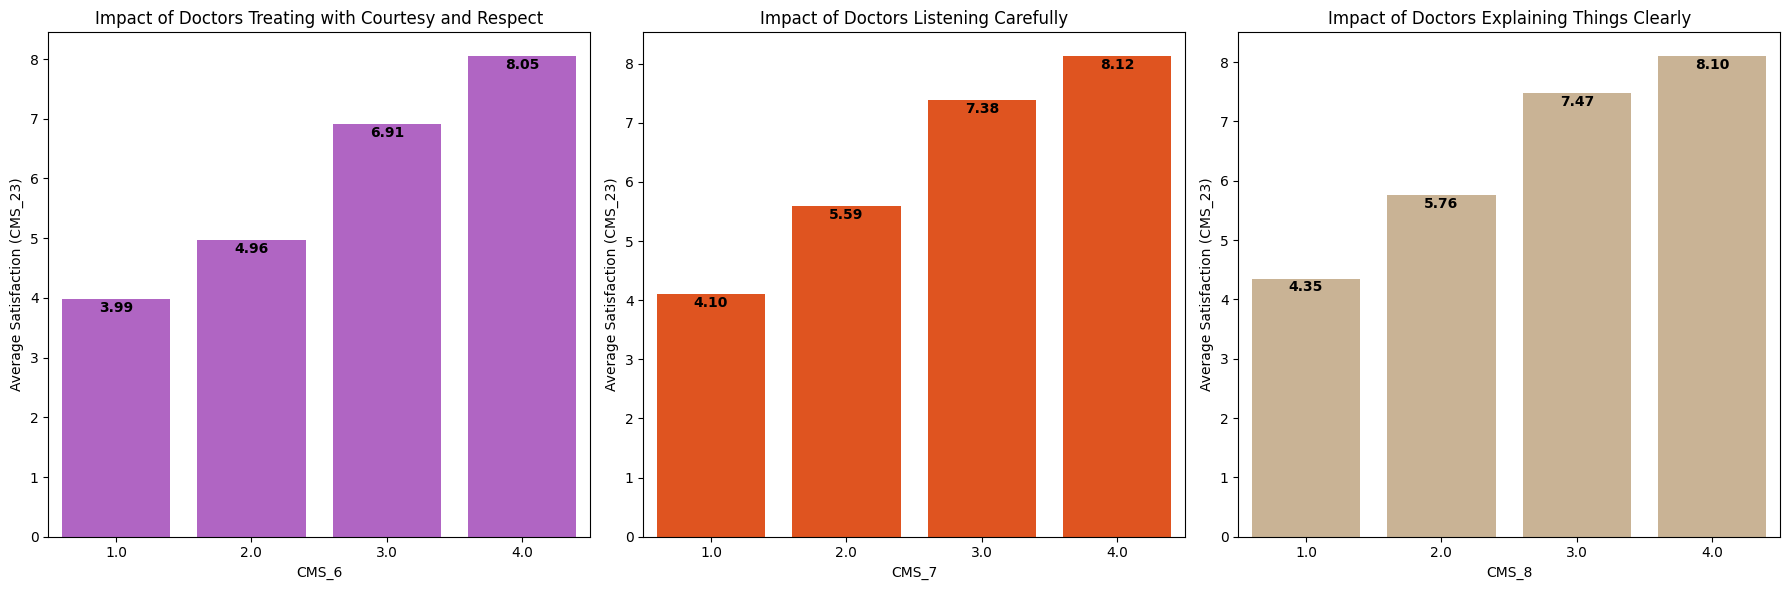

In [24]:
#Doctor Bar Graphs

#Set color palette for doctor bar graphs
doctor_colors = ["#BA55D3", "#FF4500", "#D2B48C"]  #MediumOrchid, OrangeRed, Brown

#Plotting
plt.figure(figsize=(18, 6))

#Bar plot for CMS_6
plt.subplot(1, 3, 1)
ax1 = sns.barplot(x='CMS_6', y='CMS_23', data=hosp_data_clean, errorbar=None, color=doctor_colors[0])
plt.title('Impact of Doctors Treating with Courtesy and Respect')
plt.xlabel('CMS_6')
plt.ylabel('Average Satisfaction (CMS_23)')

#Annotate bars for CMS_6
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(format(height, '.2f'), 
                 (p.get_x() + p.get_width() / 2., height - 0.15), 
                 ha='center', va='center', 
                 xytext=(0, 0), 
                 textcoords='offset points',
                 color='black', weight='bold')

#Bar plot for CMS_7
plt.subplot(1, 3, 2)
ax2 = sns.barplot(x='CMS_7', y='CMS_23', data=hosp_data_clean, errorbar=None, color=doctor_colors[1])
plt.title('Impact of Doctors Listening Carefully')
plt.xlabel('CMS_7')
plt.ylabel('Average Satisfaction (CMS_23)')

#Annotate bars for CMS_7
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(format(height, '.2f'), 
                 (p.get_x() + p.get_width() / 2., height - 0.15), 
                 ha='center', va='center', 
                 xytext=(0, 0), 
                 textcoords='offset points',
                 color='black', weight='bold')

#Bar plot for CMS_8
plt.subplot(1, 3, 3)
ax3 = sns.barplot(x='CMS_8', y='CMS_23', data=hosp_data_clean, errorbar=None, color=doctor_colors[2])
plt.title('Impact of Doctors Explaining Things Clearly')
plt.xlabel('CMS_8')
plt.ylabel('Average Satisfaction (CMS_23)')

#Annotate bars for CMS_8
for p in ax3.patches:
    height = p.get_height()
    ax3.annotate(format(height, '.2f'), 
                 (p.get_x() + p.get_width() / 2., height - 0.15), 
                 ha='center', va='center', 
                 xytext=(0, 0), 
                 textcoords='offset points',
                 color='black', weight='bold')

plt.tight_layout()
plt.show()

C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\3227909738.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp_data_clean['Nurse_Communication_Avg'] = hosp_data_clean[nurse_communication_columns].mean(axis=1)
C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\3227909738.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp_data_clean['Doctor_Communication_Avg'] = hosp_data_clean[doctor_communication_columns].mean(axis=1)
C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\3227909738.py:24: FutureWarnin

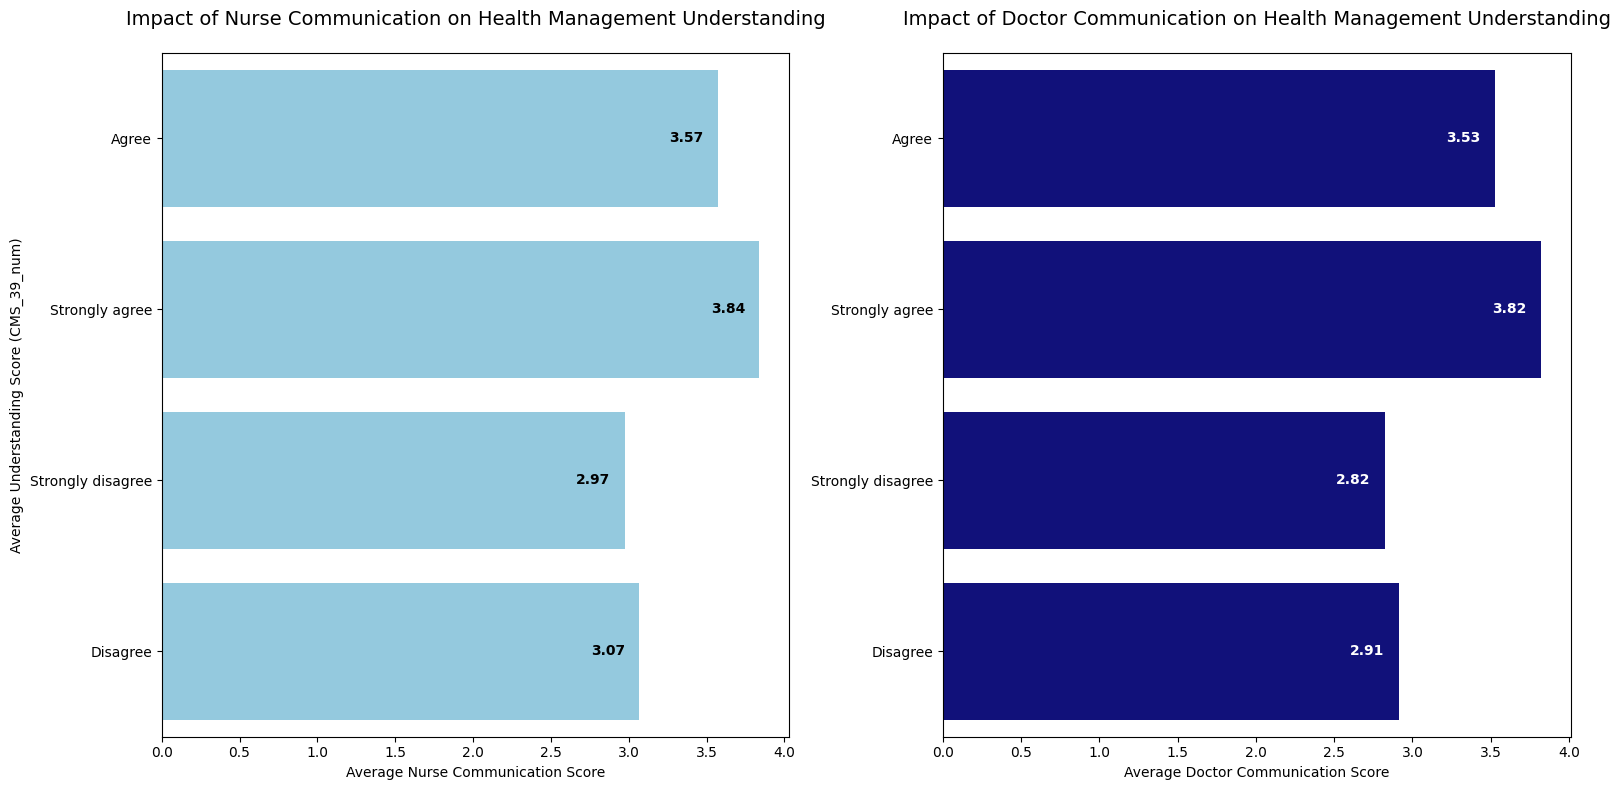

In [25]:
#Nurse and Doctor Communication Impact on Health Management Understanding

#Set variables for Communication-related CMS columns
nurse_communication_columns = ['CMS_1', 'CMS_2', 'CMS_3']
doctor_communication_columns = ['CMS_6', 'CMS_7', 'CMS_8']
target_column_39 = 'CMS_39'

#Calculate the average scores for nurse and doctor communication columns
hosp_data_clean['Nurse_Communication_Avg'] = hosp_data_clean[nurse_communication_columns].mean(axis=1)
hosp_data_clean['Doctor_Communication_Avg'] = hosp_data_clean[doctor_communication_columns].mean(axis=1)

#Create a DataFrame for plotting
plot_data = hosp_data_clean[['Nurse_Communication_Avg', 'Doctor_Communication_Avg', target_column_39]]

#Melt the DataFrame for Seaborn
plot_data_melted = plot_data.melt(id_vars=[target_column_39], value_vars=['Nurse_Communication_Avg', 'Doctor_Communication_Avg'], 
                                  var_name='Communication_Type', value_name='Communication_Avg')

#Create bar plots with uniform colors
plt.figure(figsize=(16, 8))

#Bar plot for Nurse Communication
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x='Communication_Avg', y=target_column_39, data=plot_data_melted[plot_data_melted['Communication_Type'] == 'Nurse_Communication_Avg'], ci=None, color='skyblue', )
plt.title('Impact of Nurse Communication on Health Management Understanding', fontsize=14, pad=20)
plt.xlabel('Average Nurse Communication Score')
plt.ylabel('Average Understanding Score (CMS_39_num)')

#Annotate bars
for p in ax1.patches:
    ax1.annotate(format(p.get_width(), '.2f'), 
                 (p.get_width() - 0.2, p.get_y() + p.get_height() / 2.),
                 ha='center', va='center', 
                 xytext=(0, 0), 
                 textcoords='offset points',
                 color='black', weight='bold')

#Bar plot for Doctor Communication
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x='Communication_Avg', y=target_column_39, data=plot_data_melted[plot_data_melted['Communication_Type'] == 'Doctor_Communication_Avg'], ci=None, color='darkblue')
plt.title('Impact of Doctor Communication on Health Management Understanding', fontsize=14, pad=20)
plt.xlabel('Average Doctor Communication Score')
plt.ylabel('')

#Annotate bars
for p in ax2.patches:
    ax2.annotate(format(p.get_width(), '.2f'), 
                 (p.get_width() - 0.2, p.get_y() + p.get_height() / 2.),
                 ha='center', va='center', 
                 xytext=(0, 0), 
                 textcoords='offset points',
                 color='white', weight='bold')

plt.tight_layout()
plt.show()

C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\3551507119.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax3 = sns.barplot(x='Nurse_Communication_Avg', y='CMS_26', data=hosp_data_clean, ci=None, color='skyblue', order=['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'])
C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\3551507119.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax4 = sns.barplot(x='Doctor_Communication_Avg', y='CMS_26', data=hosp_data_clean, ci=None, color='darkblue', order=['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'])


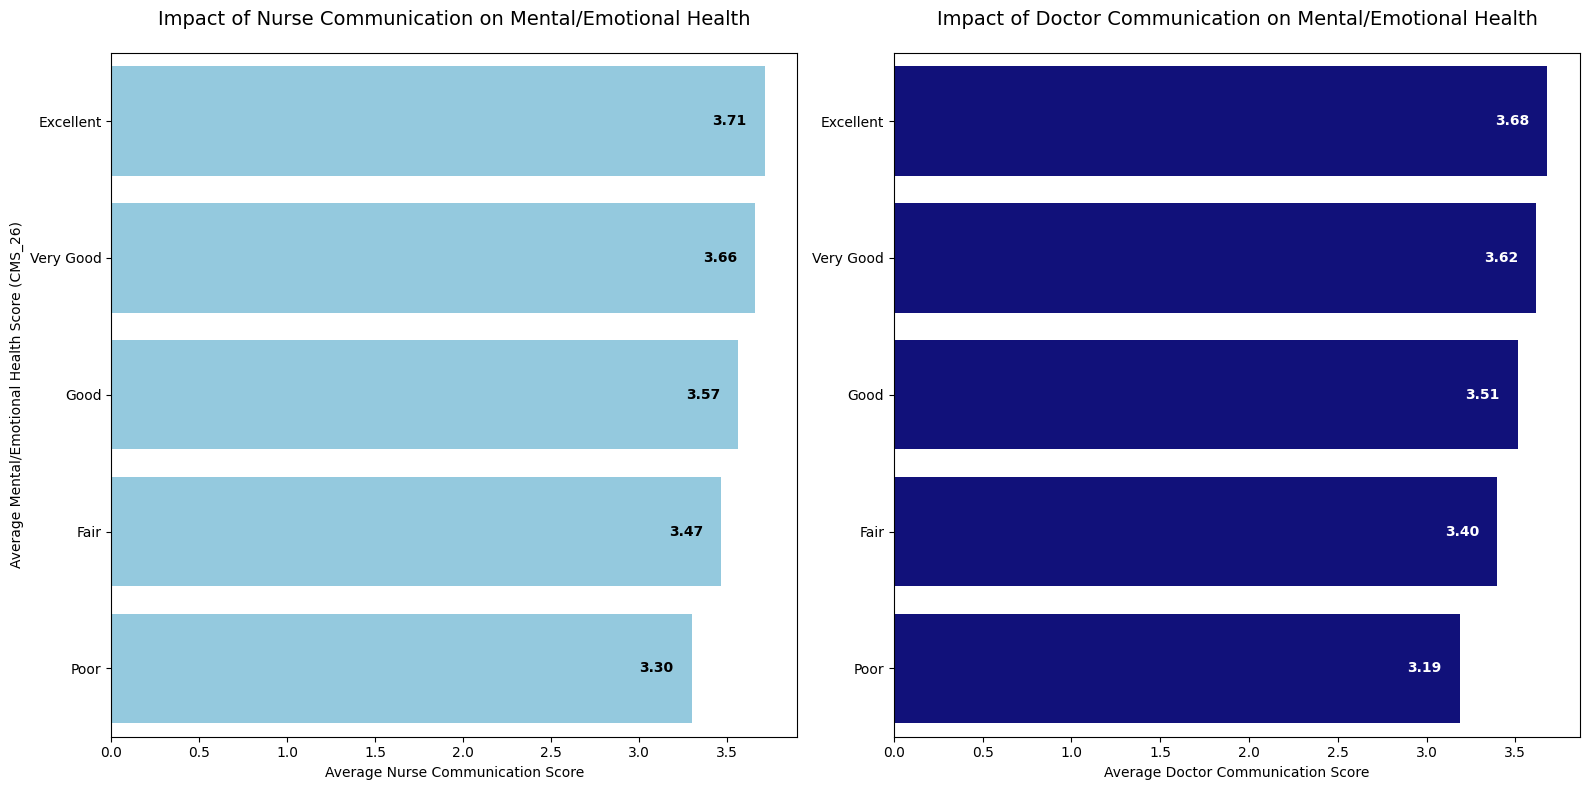

In [26]:
#Create bar plots comparing the impact of communication on mental or emotional health
plt.figure(figsize=(16, 8))

#Bar plot for Nurse Communication and Mental/Emotional Health
plt.subplot(1, 2, 1)
ax3 = sns.barplot(x='Nurse_Communication_Avg', y='CMS_26', data=hosp_data_clean, ci=None, color='skyblue', order=['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'])
plt.title('Impact of Nurse Communication on Mental/Emotional Health', fontsize=14, pad=20)
plt.xlabel('Average Nurse Communication Score')
plt.ylabel('Average Mental/Emotional Health Score (CMS_26)')

#Annotate bars
for p in ax3.patches:
    ax3.annotate(format(p.get_width(), '.2f'), 
                 (p.get_width() - 0.2, p.get_y() + p.get_height() / 2.),
                 ha='center', va='center', 
                 xytext=(0, 0), 
                 textcoords='offset points',
                 color='black', weight='bold')

#Bar plot for Doctor Communication and Mental/Emotional Health
plt.subplot(1, 2, 2)
ax4 = sns.barplot(x='Doctor_Communication_Avg', y='CMS_26', data=hosp_data_clean, ci=None, color='darkblue', order=['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'])
plt.title('Impact of Doctor Communication on Mental/Emotional Health', fontsize=14, pad=20)
plt.xlabel('Average Doctor Communication Score')
plt.ylabel('')

#Annotate bars
for p in ax4.patches:
    ax4.annotate(format(p.get_width(), '.2f'), 
                 (p.get_width() - 0.2, p.get_y() + p.get_height() / 2.),
                 ha='center', va='center', 
                 xytext=(0, 0), 
                 textcoords='offset points',
                 color='white', weight='bold')

plt.tight_layout()
plt.show()


C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\3110405578.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax1 = sns.barplot(x='Nurse_Communication_Avg', y='CMS_25', data=hosp_data_clean, ci=None, color='skyblue', order=['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'])
C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\3110405578.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax2 = sns.barplot(x='Doctor_Communication_Avg', y='CMS_25', data=hosp_data_clean, ci=None, color='darkblue', order=['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'])


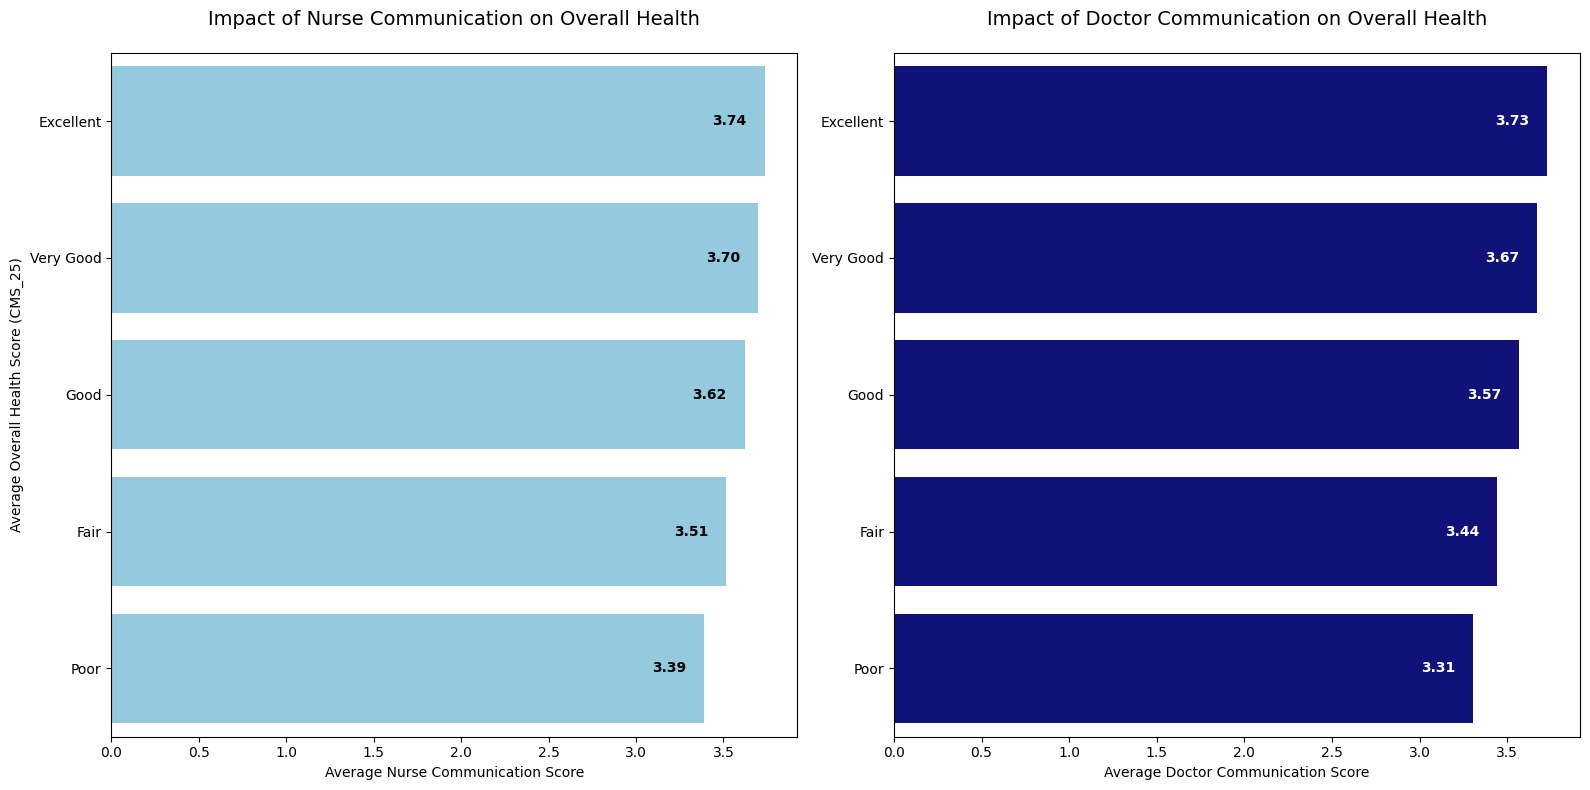

In [27]:
#Nurse vs doctor impact on overall health

#Create bar plots comparing the impact of communication on overall health
plt.figure(figsize=(16, 8))

#Bar plot for Nurse Communication and Overall Health
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x='Nurse_Communication_Avg', y='CMS_25', data=hosp_data_clean, ci=None, color='skyblue', order=['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'])
plt.title('Impact of Nurse Communication on Overall Health', fontsize=14, pad=20)
plt.xlabel('Average Nurse Communication Score')
plt.ylabel('Average Overall Health Score (CMS_25)')

#Annotate bars
for p in ax1.patches:
    ax1.annotate(format(p.get_width(), '.2f'), 
                 (p.get_width() - 0.2, p.get_y() + p.get_height() / 2.),
                 ha='center', va='center', 
                 xytext=(0, 0), 
                 textcoords='offset points',
                 color='black', weight='bold')

#Bar plot for Doctor Communication and Overall Health
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x='Doctor_Communication_Avg', y='CMS_25', data=hosp_data_clean, ci=None, color='darkblue', order=['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'])
plt.title('Impact of Doctor Communication on Overall Health', fontsize=14, pad=20)
plt.xlabel('Average Doctor Communication Score')
plt.ylabel('')

#Annotate bars
for p in ax2.patches:
    ax2.annotate(format(p.get_width(), '.2f'), 
                 (p.get_width() - 0.2, p.get_y() + p.get_height() / 2.),
                 ha='center', va='center', 
                 xytext=(0, 0), 
                 textcoords='offset points',
                 color='white', weight='bold')

plt.tight_layout()
plt.show()


C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\2697276844.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp_data_clean[col] = hosp_data_clean[col].map(ordinal_mapping)
C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\2697276844.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp_data_clean[col] = hosp_data_clean[col].map(ordinal_mapping)
C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\2697276844.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

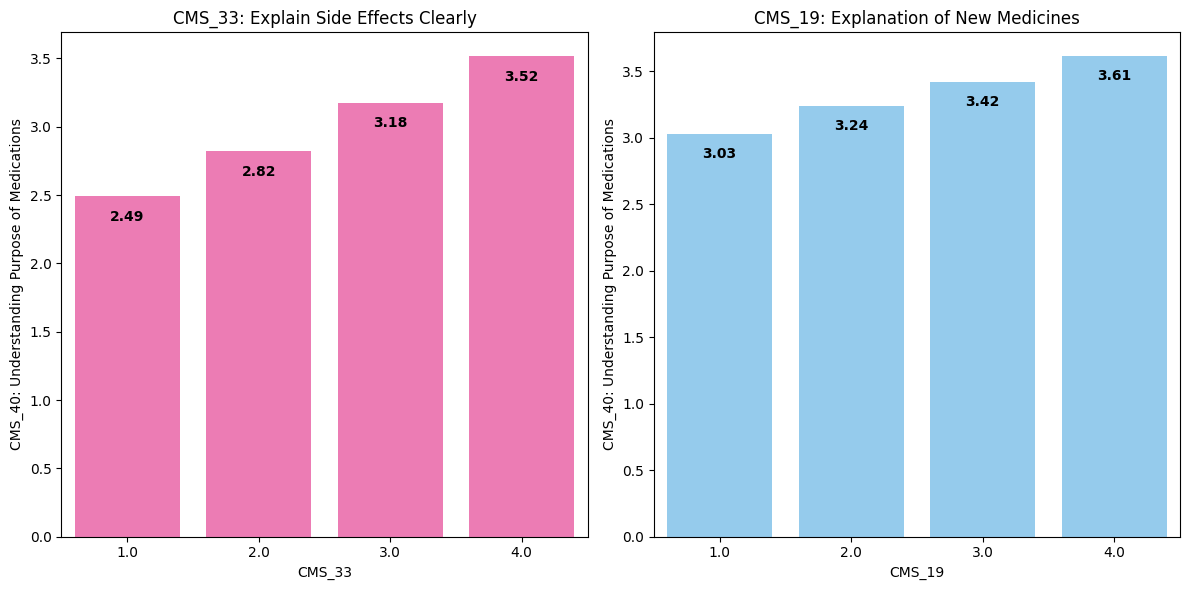

In [28]:
#Medicine Bar graphs

#Set CMS columns that are related to medicine
medicine_columns = ['CMS_33', 'CMS_19', 'CMS_40']

#Define a mapping for CMS_40
cms_40_mapping = {
    'Strongly agree': 4,
    'Agree': 3,
    'Disagree': 2,
    'Strongly disagree': 1,
    np.nan: np.nan  #Make sure NaN values remain as NaN
}

#Apply the mapping to the medicine columns
for col in medicine_columns[:-1]:  #Exclude CMS_40 as it has a different mapping
    hosp_data_clean[col] = hosp_data_clean[col].map(ordinal_mapping)

#Apply the mapping to CMS_40
hosp_data_clean['CMS_40'] = hosp_data_clean['CMS_40'].map(cms_40_mapping)

#Make sure CMS_40 is numeric 
hosp_data_clean['CMS_40'] = pd.to_numeric(hosp_data_clean['CMS_40'], errors='coerce')

#Drop rows with missing values in the relevant columns
hosp_data_clean = hosp_data_clean.dropna(subset=medicine_columns)

#Set a new palette for medicine graph
medication_colors = ["#FF69B4", "#87CEFA"]  #HotPink, LightSkyBlue

#Plotting
plt.figure(figsize=(12, 6))

#Bar plot for CMS_33
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x='CMS_33', y='CMS_40', data=hosp_data_clean, errorbar=None, color=medication_colors[0])
plt.title('CMS_33: Explain Side Effects Clearly')
plt.xlabel('CMS_33')
plt.ylabel('CMS_40: Understanding Purpose of Medications')

#Annotate bars for CMS_33
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(format(height, '.2f'), 
                 (p.get_x() + p.get_width() / 2., height - 0.15), 
                 ha='center', va='center', 
                 xytext=(0, 0), 
                 textcoords='offset points',
                 color='black', weight='bold')

#Bar plot for CMS_19
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x='CMS_19', y='CMS_40', data=hosp_data_clean, errorbar=None, color=medication_colors[1])
plt.title('CMS_19: Explanation of New Medicines')
plt.xlabel('CMS_19')
plt.ylabel('CMS_40: Understanding Purpose of Medications')

#Annotate bars for CMS_19
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(format(height, '.2f'), 
                 (p.get_x() + p.get_width() / 2., height - 0.15), 
                 ha='center', va='center', 
                 xytext=(0, 0), 
                 textcoords='offset points',
                 color='black', weight='bold')

plt.tight_layout()
plt.show()


C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\1012386662.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax1 = sns.barplot(x='CMS_21', y='CMS_23', data=hosp_data_clean, ci=None, palette=yes_no_colors, order=['Yes', 'No'])
C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\1012386662.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x='CMS_21', y='CMS_23', data=hosp_data_clean, ci=None, palette=yes_no_colors, order=['Yes', 'No'])
C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\1012386662.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax2 = sns.barplot(x='CMS_22', y='CMS_23', data=hosp_data_clean, ci=None, palette=yes_no_colors, order=['Yes', 'No'])
C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\1012386662.py:30: Future

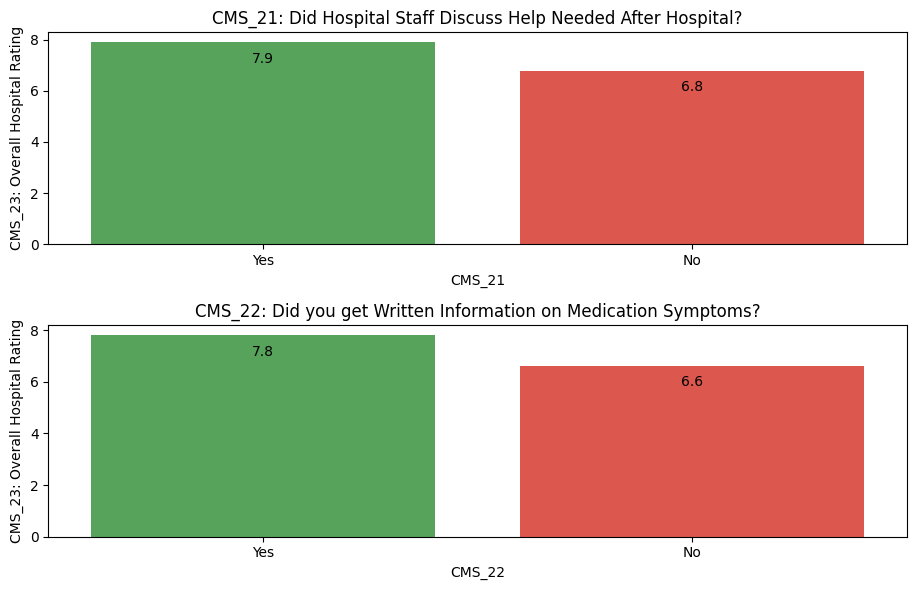

In [29]:
#Aftermath-related CMS columns
aftermath_columns = ['CMS_21', 'CMS_22', 'CMS_23']

#Set green color for "yes" and and red color for "no"
yes_no_colors = {"Yes": "#4CAF50", "No": "#F44336"}  

#Annotate bars with their values
def annotate_bars(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.1f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, -12),  #Positioning lower
                    textcoords = 'offset points',
                    color='black')

#Plotting
plt.figure(figsize=(18, 6))

#Bar plot for CMS_21
plt.subplot(2, 2, 1)
ax1 = sns.barplot(x='CMS_21', y='CMS_23', data=hosp_data_clean, ci=None, palette=yes_no_colors, order=['Yes', 'No'])
plt.title('CMS_21: Did Hospital Staff Discuss Help Needed After Hospital?')
plt.xlabel('CMS_21')
plt.ylabel('CMS_23: Overall Hospital Rating')
annotate_bars(ax1)

#Bar plot for CMS_22
plt.subplot(2, 2, 3)
ax2 = sns.barplot(x='CMS_22', y='CMS_23', data=hosp_data_clean, ci=None, palette=yes_no_colors, order=['Yes', 'No'])
plt.title('CMS_22: Did you get Written Information on Medication Symptoms?')
plt.xlabel('CMS_22')
plt.ylabel('CMS_23: Overall Hospital Rating')
annotate_bars(ax2)

plt.tight_layout()
plt.show()

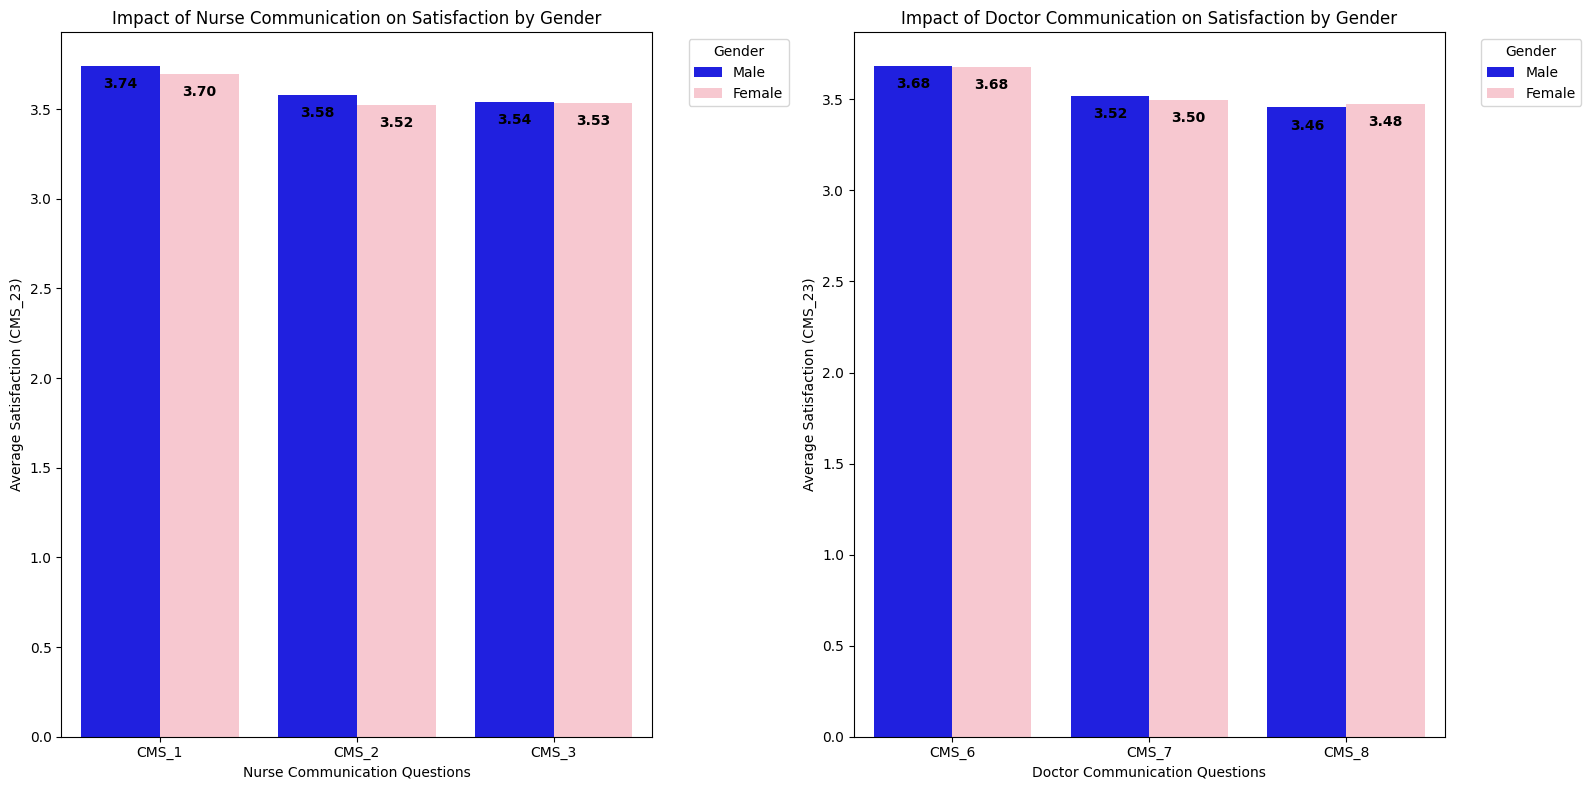

In [30]:
#Map the 'SEX' column to binary values
sex_mapping = {'Male': 0, 'Female': 1}
hosp_data_clean['SEX'] = hosp_data_clean['SEX'].map(sex_mapping)

#Define sex palette
sex_palette = {0: 'blue', 1: 'pink'}

#Set variables for nurse and doctor communication-related columns
nurse_communication_columns = ['CMS_1', 'CMS_2', 'CMS_3']
doctor_communication_columns = ['CMS_6', 'CMS_7', 'CMS_8']

#Create bar plots comparing the impact of communication between genders
plt.figure(figsize=(16, 8))

#Bar plot for nurse communication-related questions
plt.subplot(1, 2, 1)
nurse_melted = hosp_data_clean.melt(id_vars=['SEX'], value_vars=nurse_communication_columns, var_name='Question', value_name='Score')
ax1 = sns.barplot(x='Question', y='Score', hue='SEX', data=nurse_melted, errorbar=None, palette=sex_palette)
plt.title('Impact of Nurse Communication on Satisfaction by Gender')
plt.xlabel('Nurse Communication Questions')
plt.ylabel('Average Satisfaction (CMS_23)')

#Annotate bars for nurse communication
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(format(height, '.2f'), 
                 (p.get_x() + p.get_width() / 2., height - 0.1), 
                 ha='center', va='center', 
                 xytext=(0, 0), 
                 textcoords='offset points',
                 color='black', weight='bold')

#Bar plot for doctor communication-related questions
plt.subplot(1, 2, 2)
doctor_melted = hosp_data_clean.melt(id_vars=['SEX'], value_vars=doctor_communication_columns, var_name='Question', value_name='Score')
ax2 = sns.barplot(x='Question', y='Score', hue='SEX', data=doctor_melted, errorbar=None, palette=sex_palette)
plt.title('Impact of Doctor Communication on Satisfaction by Gender')
plt.xlabel('Doctor Communication Questions')
plt.ylabel('Average Satisfaction (CMS_23)')

#Annotate bars for doctor communication
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(format(height, '.2f'), 
                 (p.get_x() + p.get_width() / 2., height - 0.1), 
                 ha='center', va='center', 
                 xytext=(0, 0), 
                 textcoords='offset points',
                 color='black', weight='bold')

#Move the legend outside the plot
ax1.legend(title='Gender', labels=['Male', 'Female'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='Gender', labels=['Male', 'Female'], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\3895444610.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CMS_23', y='CLIENT_DESC', data=hospital_satisfaction, palette=color_palette)


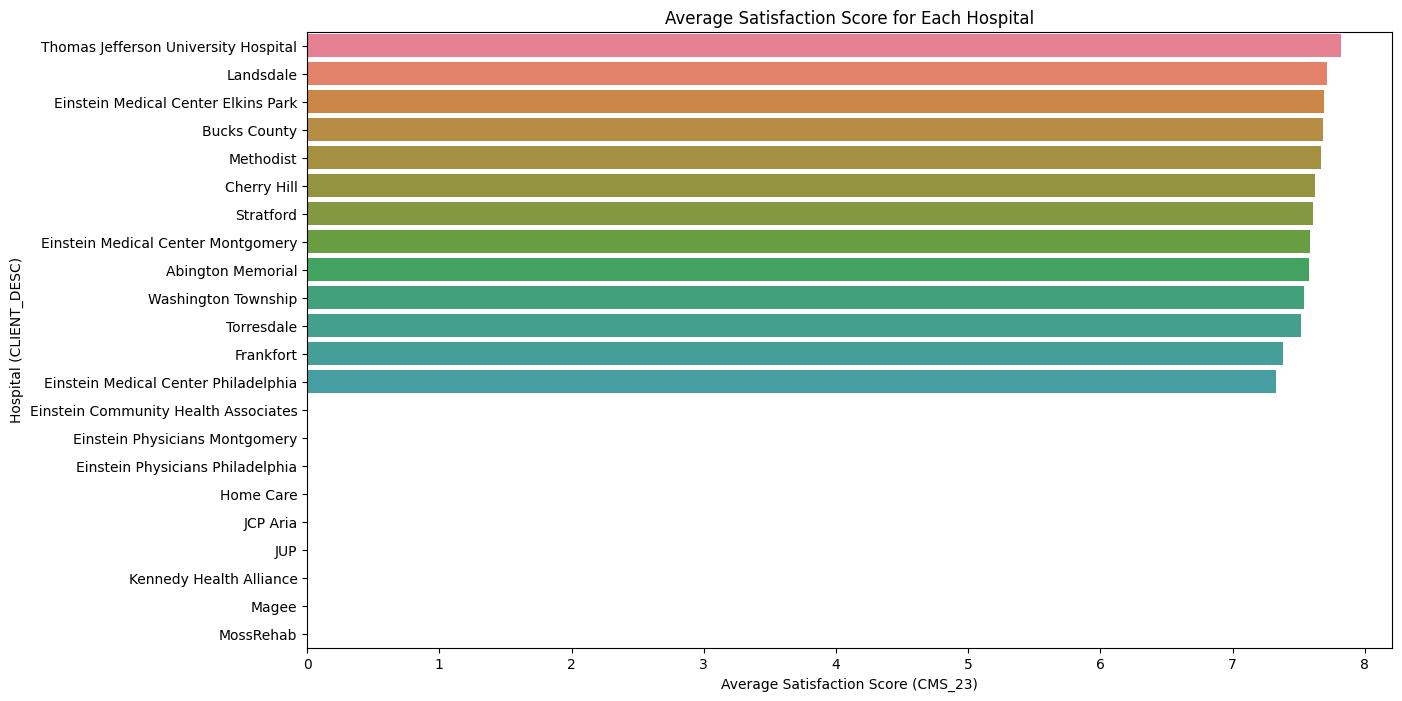

In [31]:
#Satisfaction by each hospital location

#Group by CLIENT_DESC and calculate the average satisfaction score
hospital_satisfaction = hosp_data.groupby('CLIENT_DESC')['CMS_23'].mean().reset_index()

#Sort the data for better visualization
hospital_satisfaction = hospital_satisfaction.sort_values(by='CMS_23', ascending=False)

#Define a colorful palette
color_palette = sns.color_palette("husl", len(hospital_satisfaction))  

#Create the bar graph
plt.figure(figsize=(14, 8))
sns.barplot(x='CMS_23', y='CLIENT_DESC', data=hospital_satisfaction, palette=color_palette)
plt.title('Average Satisfaction Score for Each Hospital')
plt.xlabel('Average Satisfaction Score (CMS_23)')
plt.ylabel('Hospital (CLIENT_DESC)')
plt.show()

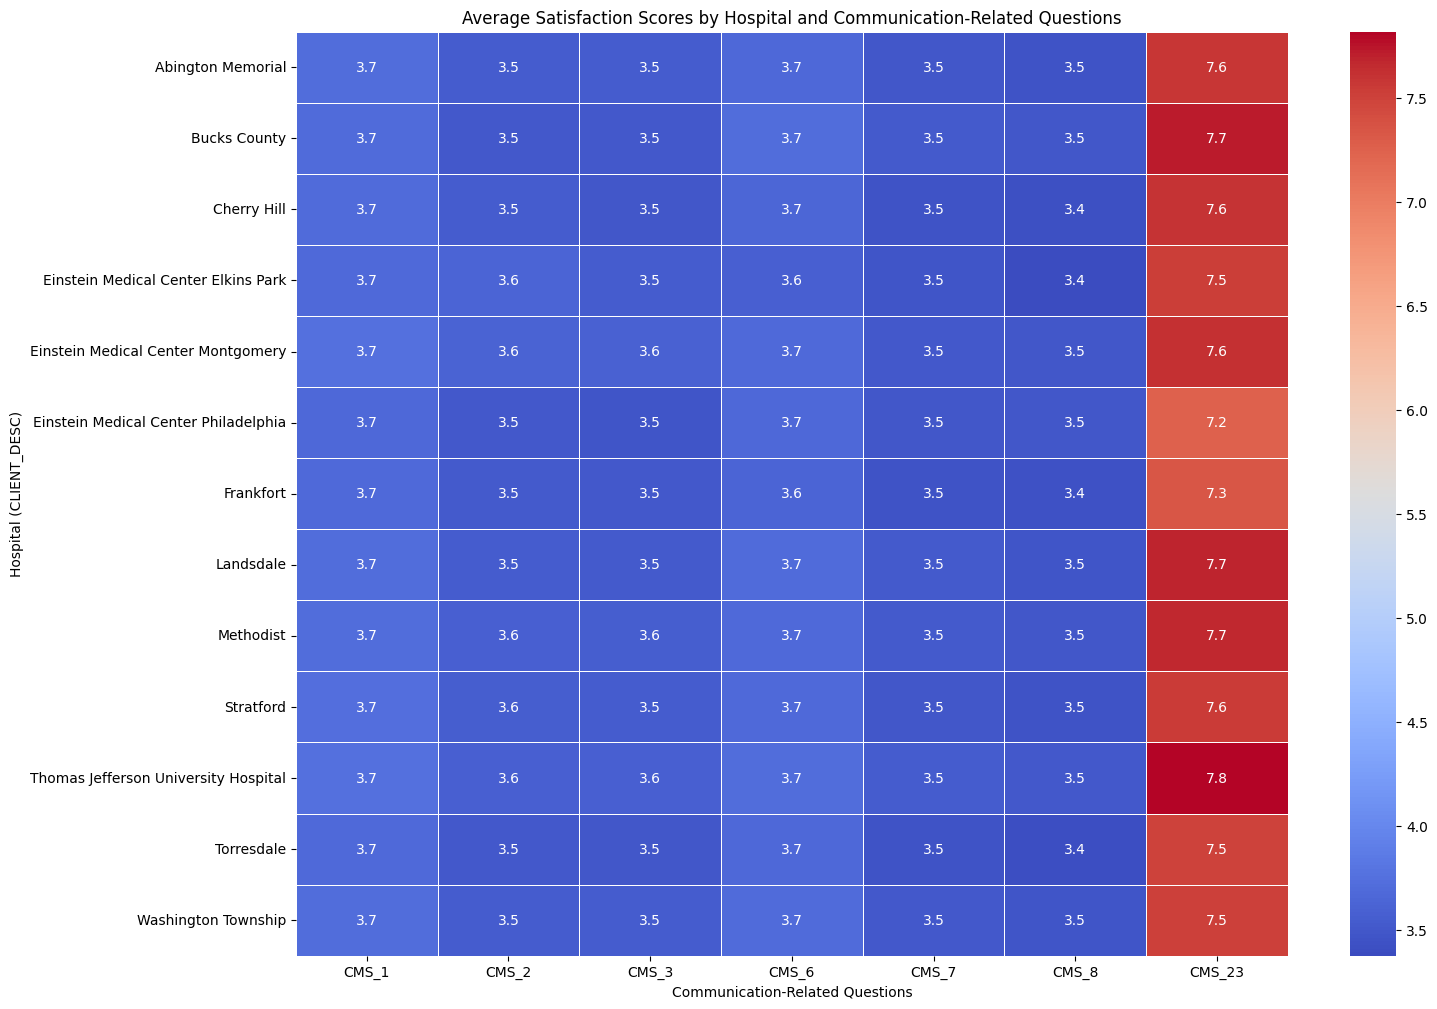

In [32]:
#Impact of communication by hospital

#Set target column
target_column = 'CMS_23'

#Group by CLIENT_DESC (hospital) and calculate the mean satisfaction score for each communication column
mean_scores = hosp_data_clean.groupby('CLIENT_DESC')[communication_columns + [target_column]].mean()

#Create a heatmap to show the average satisfaction scores by hospital
plt.figure(figsize=(16, 12))
sns.heatmap(mean_scores, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Average Satisfaction Scores by Hospital and Communication-Related Questions')
plt.xlabel('Communication-Related Questions')
plt.ylabel('Hospital (CLIENT_DESC)')
plt.show()

C:\Users\ariia\AppData\Local\Temp\ipykernel_20324\2229053526.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=response_counts.index, y=response_counts.values, palette=custom_palette_call)
C:\Users\ariia\AppData\Local\Temp\ipykernel_20324\2229053526.py:16: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=response_counts.index, y=response_counts.values, palette=custom_palette_call)
C:\Users\ariia\AppData\Local\Temp\ipykernel_20324\2229053526.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(response_labels)


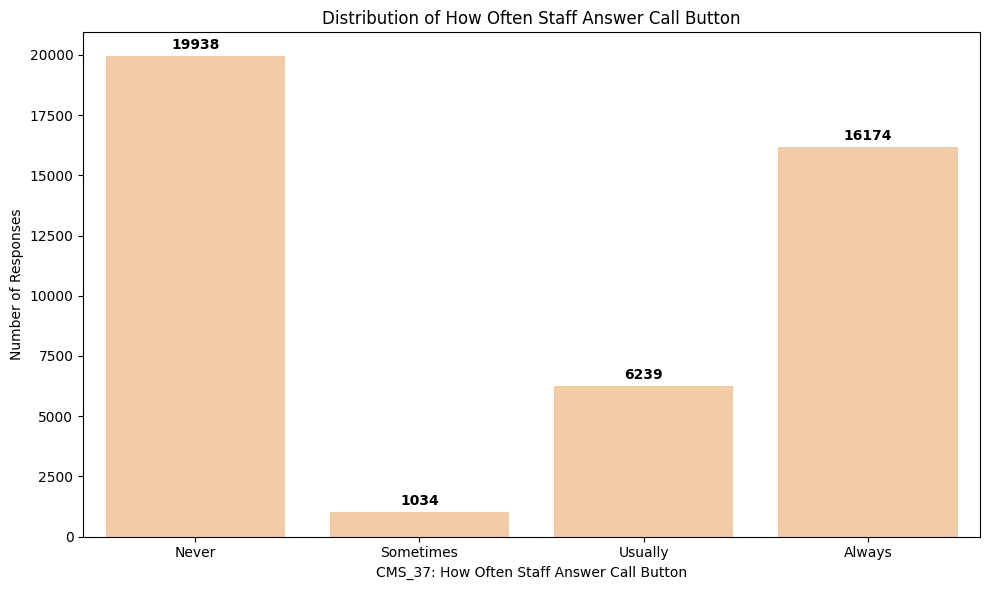

In [8]:
#Distribution graph for how often hospital staff answer the call button

#Calculate the distribution of responses for CMS_37
response_counts = hosp_data_clean['CMS_37'].value_counts().sort_index()

#Define labels for the x-axis
response_labels = ['Never', 'Sometimes', 'Usually', 'Always']

#Custom color palette
custom_palette_call = ['#ffcc99']

#Plotting
plt.figure(figsize=(10, 6))

#Create bar plot with custom palette
ax = sns.barplot(x=response_counts.index, y=response_counts.values, palette=custom_palette_call)

#Add titles and labels
plt.title('Distribution of How Often Staff Answer Call Button')
plt.xlabel('CMS_37: How Often Staff Answer Call Button')
plt.ylabel('Number of Responses')
ax.set_xticklabels(response_labels)

#Annotate bars with values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', 
                xytext=(0, 3), 
                textcoords='offset points',
                color='black', weight='bold')

#Adjust the layout to make sure everything fits without overlapping
plt.tight_layout()

#Show the graph
plt.show()

In [35]:
#See nurse communication columns
print(nurse_communication_columns)

['CMS_1', 'CMS_2', 'CMS_3']


In [ ]:
#New ML

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Example of creating a more balanced target variable
#Define the target variable: achieving a score of 8 or higher as high satisfaction
hosp_data['high_satisfaction'] = hosp_data['CMS_23'].apply(lambda x: 1 if x >= 8 else 0)

#Select relevant features
features = ['CMS_1', 'CMS_2', 'CMS_3', 'CMS_6', 'CMS_7', 'CMS_8']
target = 'high_satisfaction'

#Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(hosp_data[features])
X_imputed_df = pd.DataFrame(X_imputed, columns=features)

#Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed_df)

#Check the distribution of the new target variable
print(hosp_data[target].value_counts())


C:\Users\ariia\AppData\Local\Temp\ipykernel_7668\2080373371.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp_data['high_satisfaction'] = hosp_data['CMS_23'].apply(lambda x: 1 if x >= 8 else 0)


high_satisfaction
0    1343971
1      34774
Name: count, dtype: int64


In [44]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, hosp_data[target], test_size=0.2, random_state=42)


In [45]:
#Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_model.fit(X_train, y_train)

#Make predictions on the test set
y_pred = rf_model.predict(X_test)


Accuracy: 0.9771567621278772
Confusion Matrix:
[[266574   2210]
 [  4089   2876]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    268784
           1       0.57      0.41      0.48      6965

    accuracy                           0.98    275749
   macro avg       0.78      0.70      0.73    275749
weighted avg       0.97      0.98      0.98    275749



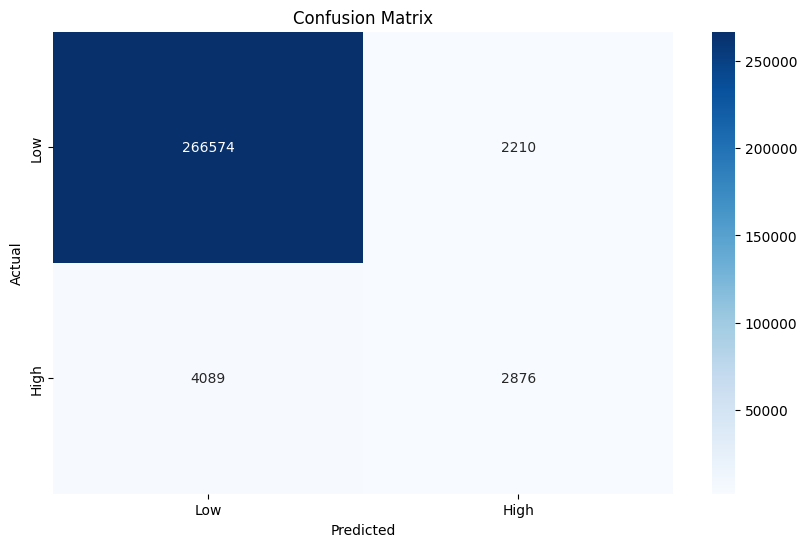

In [46]:
#Evaluate the model by providing a Classification Report
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

In [ ]:
from sklearn.model_selection import cross_val_score

#Perform cross-validation
cv_scores = cross_val_score(rf_model, X_scaled, hosp_data[target], cv=5)

#Print cross-validation scores
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {cv_scores.mean():.4f}')


Cross-Validation Scores: [0.97873428 0.96962818 0.98144327 0.97684126 0.9751078 ]
Mean CV Score: 0.9764


In [49]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

#Define the parameters
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(10, 30),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

#Start the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=20,  #This is the number of iterations
                                   cv=5, n_jobs=-1, verbose=2, random_state=42)

#Fit the RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

#Get the best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

#Evaluate the best model
best_y_pred = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, best_y_pred)
best_conf_matrix = confusion_matrix(y_test, best_y_pred)
best_class_report = classification_report(y_test, best_y_pred)

#Print
print(f'Best Parameters: {best_params}')
print(f'Best Accuracy: {best_accuracy:.4f}')
print('Best Confusion Matrix:')
print(best_conf_matrix)
print('Best Classification Report:')
print(best_class_report)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'max_depth': 21, 'min_samples_leaf': 9, 'min_samples_split': 18, 'n_estimators': 158}
Best Accuracy: 0.9772
Best Confusion Matrix:
[[266598   2186]
 [  4108   2857]]
Best Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    268784
           1       0.57      0.41      0.48      6965

    accuracy                           0.98    275749
   macro avg       0.78      0.70      0.73    275749
weighted avg       0.97      0.98      0.98    275749



In [50]:
#Perform cross-validation
cv_scores = cross_val_score(best_model, X_scaled, hosp_data[target], cv=5)

#Print cross-validation scores
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {cv_scores.mean():.4f}')


Cross-Validation Scores: [0.97871252 0.97016852 0.98148316 0.97691016 0.97523835]
Mean CV Score: 0.9765


In [51]:
from sklearn.preprocessing import PolynomialFeatures

#Create interaction features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interaction = poly.fit_transform(X_imputed_df)

#Combine original and interaction features
X_combined = np.hstack((X_scaled, X_interaction))

#Split the combined data into training and testing sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, hosp_data[target], test_size=0.2, random_state=42)

#Train the model with combined features
best_model.fit(X_train_combined, y_train_combined)

#Evaluate the model with combined features
combined_y_pred = best_model.predict(X_test_combined)
combined_accuracy = accuracy_score(y_test_combined, combined_y_pred)
combined_conf_matrix = confusion_matrix(y_test_combined, combined_y_pred)
combined_class_report = classification_report(y_test_combined, combined_y_pred)

#Print
print(f'Combined Features Accuracy: {combined_accuracy:.4f}')
print('Combined Features Confusion Matrix:')
print(combined_conf_matrix)
print('Combined Features Classification Report:')
print(combined_class_report)


Combined Features Accuracy: 0.9772
Combined Features Confusion Matrix:
[[266580   2204]
 [  4095   2870]]
Combined Features Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    268784
           1       0.57      0.41      0.48      6965

    accuracy                           0.98    275749
   macro avg       0.78      0.70      0.73    275749
weighted avg       0.97      0.98      0.98    275749



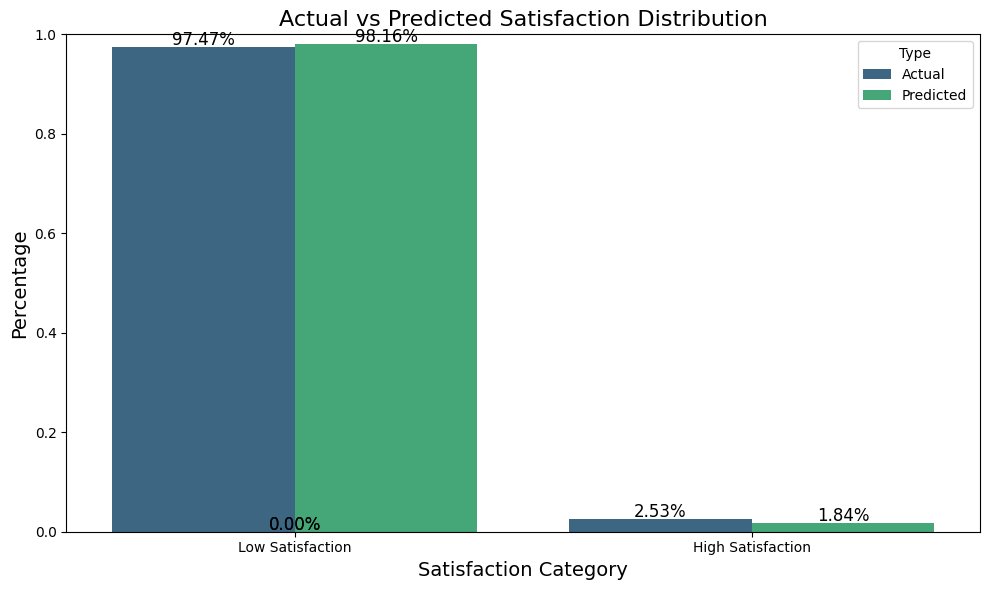

In [61]:
#Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

#Calculate the actual and predicted values counts
actual_counts = y_test.value_counts()
predicted_counts = pd.Series(y_pred).value_counts()

#Create a DataFrame for plotting
accuracy_data = pd.DataFrame({
    'Category': ['Low Satisfaction', 'High Satisfaction'],
    'Actual': actual_counts,
    'Predicted': predicted_counts
}).fillna(0)

#Normalize the counts to represent percentages
accuracy_data['Actual'] = accuracy_data['Actual'] / accuracy_data['Actual'].sum()
accuracy_data['Predicted'] = accuracy_data['Predicted'] / accuracy_data['Predicted'].sum()

#Melt the DataFrame for easier plotting
accuracy_data_melted = accuracy_data.melt(id_vars='Category', value_vars=['Actual', 'Predicted'], var_name='Type', value_name='Percentage')

#Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=accuracy_data_melted, x='Category', y='Percentage', hue='Type', palette='viridis')

#Annotate the bars with the percentage values
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

#Set plot title and labels
plt.title('Actual vs Predicted Satisfaction Distribution', fontsize=16)
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Satisfaction Category', fontsize=14)

#Show the plot
plt.legend(title='Type', loc='upper right')
plt.tight_layout()
plt.show()